## EN.605.646.81: Natural Language Processing, Fall 2024
### Applied and Computational Mathematics
### Johns Hopkins University
### Andres Davila Corujo

### Lab 05: Sequence Labeling

This lab needs to run on a GPU. Click the 'runtime' menu above, select 'change runtime type' and verify you're using a GPU.

First, install the FLAIR package. This can take as long as three minutes depending on your GPU.

In [ ]:
!pip install -q flair --quiet

You might see version errors, but they do not appear to affect the tagger's operation.

Import various modules.

In [ ]:
import flair
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from pathlib import Path

Mount your Google drive. You will be prompted to sign in to your Google account.

In [ ]:
from google.colab import drive
gdrive_mount = '/content/drive'
drive.mount(gdrive_mount, force_remount=True)

Mounted at /content/drive


Create a directory to house your project, and move to it. The ! spawns a new process, while the % executes the command in the current process. Note that we need to put quotes around the directory name to run this in a Notebook because in their infinite wisdom Google has placed a space in the default gdrive path.

In [ ]:
# Change this path if you'd like to work on your lab in a different directory:
labdir = '/content/drive/My Drive/Teaching/605.646/Fall 2024/lab05'
!mkdir -p "$labdir"
%cd "$labdir"

/content/drive/My Drive/Teaching/605.646/Fall 2024/lab05


Now, outside of Colab, obtain the file ```conll03-englishversion.gz``` from Canvas, ungzip it, and place the resulting directory in your $labdir. Notice that the data is broen into training, dev (called ```valid.txt``` here) and testing partitions.

In [ ]:
datadir = f"{labdir}/conll03-englishversion"

!ls "$datadir"

metadata	  train_125000.txt  train_200000.txt  train_50000.txt  valid.txt
test.txt	  train_150000.txt  train_225000.txt  train_75000.txt
train_100000.txt  train_175000.txt  train_25000.txt   train.txt


## Assignment

A. (10 points) Train a named entity recognizer as described above on the ```train.txt``` partition of the CoNLL 2003 English NER data.
This will be your 'base run.'
The system will report dev scores at each iteration.
Choose the number of epochs you will use for all of your runs.
Within 20 iterations you should see F1 scores on the dev partition of 95% or better.
You may choose a higher number if you want to see how good your system can get.
You may choose a lower number if you are running out of resources, but be sure to run at least ten epochs.
Report overall precision, recall, and F1 on the test set, as well as precision, recall, and F1 for each of the identified entity types.
Create a plot of the (decreasing) loss values from the training process,
where the x-axis is epoch and the y-axis is loss.
Then, train the system three more times on the same test data.
The purpose here is to see the the variation in scores caused by the randomness inherent in training a neural system.
Report your minimum, mean (of the four values),
and maximum overall F1 scores on the test data.
Plot the F1 performance on both the dev and test data,
where the x-axis is epoch and the y-axis is F1.
You will find all of these data in ```loss.tsv```.

B. (10 points) Examine how performance improves as more training data is used.
The training file has about 220K lines.
First, divide the data into 25K line chunks (preferably splitting between sentences).
[Note: you might be able to use FLAIR's ```Corpus.downsample``` for this, although I have not tried that.]
Then incrementally, train a system on the first chunk, the first two chunks, the first three chunks, etc.
Run each on the same number of iterations as your base run.
Plot the F1 learning curve as additional training data is made available,
where the x-axis is the amount of training data and the y-axis is F1.

C. (10 points) Study how performance changes when we don’t care about entity types.
First, create copies of both the training and the test data and map all entity types in the copies onto a single entity type, ENT
(i.e., map B-PER to B-ENT, I-PER to I-ENT, etc.).
You will end up with just three tags: B-ENT, I-ENT, and O.
Retrain the system on the new data, using the same number of iterations as you did in your first training.
Compare the scores in overall precision, recall, and F1, when type information is included
(using your base run) against this new run that maps all types to ENT.
Describe why you think there is/is not a difference.

D. (10 points) Explore how the system works on examples of your own selection.
First, create a new test file containing at least ten sentences.
You should include at least ten named entities of each of the three types PER, ORG, and LOC.
Your examples should include entities you think will be easy to identify, as well as a variety of difficult cases.
Run the tagger from the best saved model on your test examples.

Include a list of your sentences and the named entities the system found in your sentences in your pdf submission.
Indicate whether the system failed on any of your easy examples, and describe how it fared on your difficult examples.

## Submissions

As usual, your submission is to be a single pdf file.
Please do not submit a huge file.
There is no need to include outputs beyond what is requested.
If your pdf is longer than twenty or thirty pages,
you need to cut something out.
Remember that Colab/Jupyter notebooks have a tendency to truncate outputs over a certain width or length.
Please check your pdf submission to make sure that all the output you want to appear in it is actually there and has not run off the edge of the page.

## Assignment

## (A) Named Entity Recognizer (NER)

In [ ]:
# define type
label_type = 'ner'
runname = 'flair-ner-conll-eng'
# define corpus
columns = {0: 'text', 1: 'pos', 2: 'chunk', 3: 'ner'}
corpus = ColumnCorpus(datadir, columns, train_file="train.txt", dev_file="valid.txt", test_file="test.txt")
label_dict = corpus.make_label_dictionary(
    label_type=label_type,
    add_unk=False
)
# create embeddings
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)
# define tagger for NER
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type)
# trainer
trainer = ModelTrainer(tagger, corpus)

# 7. Train the model
TOTAL_RUNS=1
EPOCHS=10
MAX_EPOCHS=EPOCHS
runs = {}
trainer.train(f'{labdir}/resources/taggers/{runname}',
              learning_rate=0.1,
              mini_batch_size=32,
              save_model_each_k_epochs=1,
              monitor_test=True,
              max_epochs=MAX_EPOCHS,
            )

### Task
1. Report overall precision, recall, and F1 on the test set, as well as precision, recall, and F1 for each of the identified entity types.
2. Create a plot of the (decreasing) loss values from the training process, where the x-axis is epoch and the y-axis is loss. Then, train the system three more times on the same test data. The purpose here is to see the the variation in scores caused by the randomness inherent in training a neural system.

3. Report your minimum, mean (of the four values), and maximum overall F1 scores on the test data. Plot the F1 performance on both the dev and test data, where the x-axis is epoch and the y-axis is F1.

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())


In [ ]:
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('[*] OVERALL PRECISION - RECALL - F1 SCORE')
print('Precision:', precision_overall)
print('Recall:', recall_overall)
print('F1:', f1_overall)



f1_score_base = {
    'chunk_size': [],
    'f1_score': [],
    'data_type': []
}
f1_score_base['chunk_size'].append(220_000)
f1_score_base['chunk_size'].append(220_000)
f1_score_base['f1_score'].append(pd.read_csv('./resources/taggers/flair-ner-conll-eng/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_score_base['f1_score'].append(pd.read_csv('./resources/taggers/flair-ner-conll-eng/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_score_base['data_type'].append('dev-base')
f1_score_base['data_type'].append('test-base')

[*] OVERALL PRECISION - RECALL - F1 SCORE
Precision: 0.9907072203503501
Recall: 0.9905927227531822
F1: 0.99062954524872


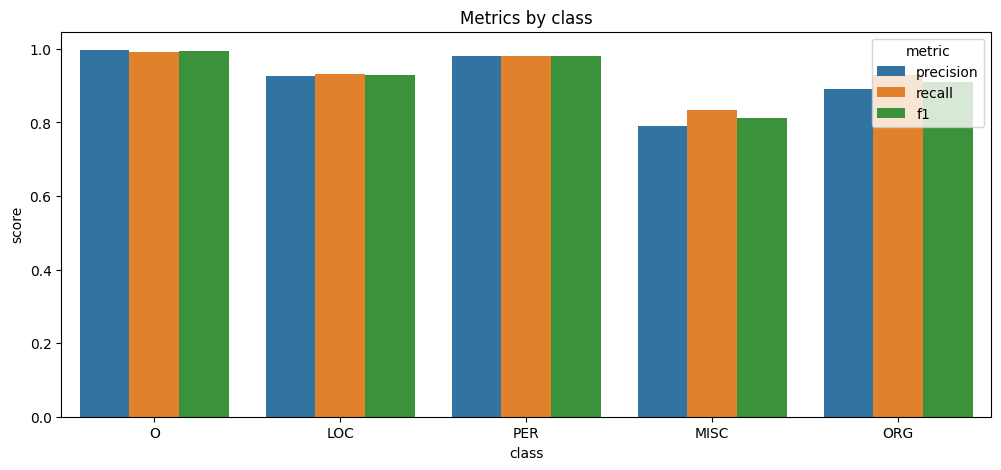

In [ ]:
# get test metrics by class
import matplotlib.pyplot as plt

precision_by_class = precision_score(test_preds['class_truth'], test_preds['class_pred'], average=None, labels=labels)
recall_by_class = recall_score(test_preds['class_truth'], test_preds['class_pred'], average=None, labels=labels)
f1_by_class = f1_score(test_preds['class_truth'], test_preds['class_pred'], average=None, labels=labels)

by_class = {
    'class': [],
    'score': [],
    'metric': []
}
by_class['class'].extend(labels)
for metric in precision_by_class:
  by_class['score'].append(metric)
  by_class['metric'].append('precision')

by_class['class'].extend(labels)
for metric in recall_by_class:
  by_class['score'].append(metric)
  by_class['metric'].append('recall')

by_class['class'].extend(labels)
for metric in f1_by_class:
  by_class['score'].append(metric)
  by_class['metric'].append('f1')

import seaborn as sns
plt.figure(figsize=(12,5))
plt.title('Metrics by class')
sns.barplot(by_class, x='class', y='score', hue='metric')
plt.show()


The plot shows the model's F1, Precision and Recall score by predicted class. We can see the model does a good job at identifying other parts of speech. We can also see the model does not do a great job of identifying MISC entities. This poor performance could be due to the wide spread of possible entities that could fall under MISC.

2024-10-17 19:15:06,989 Loss and F1 plots are saved in resources/taggers/flair-ner-conll-eng/training.png


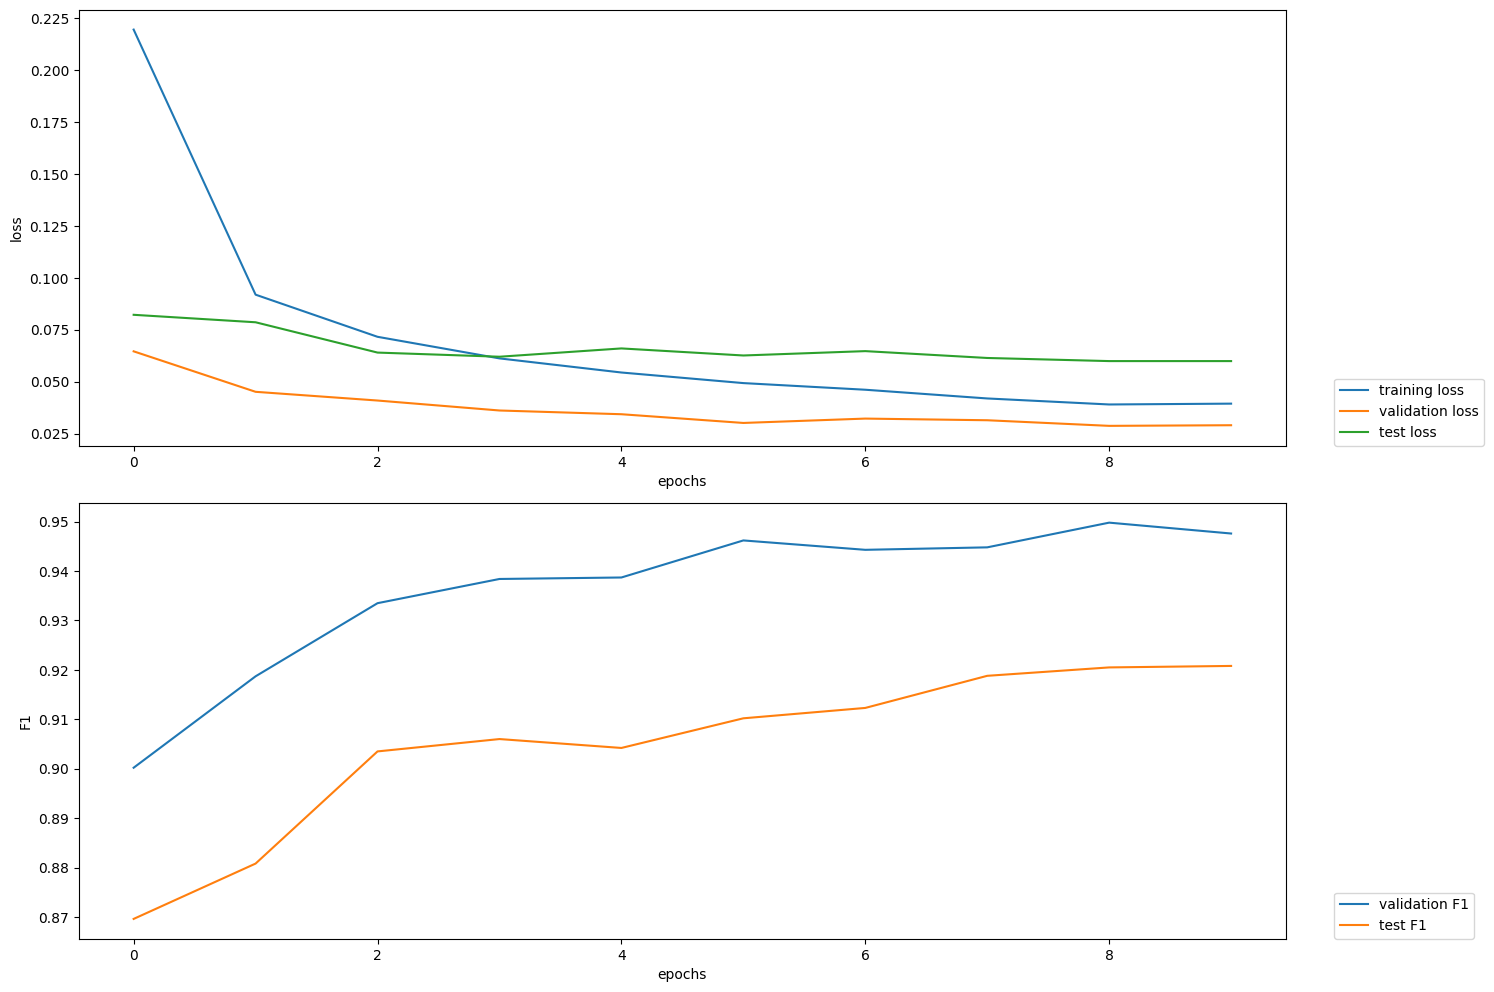

In [ ]:
# TASK 2
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('./resources/taggers/flair-ner-conll-eng/loss.tsv')


Report your minimum, mean (of the four values), and maximum overall F1 scores on the test data. Plot the F1 performance on both the dev and test data, where the x-axis is epoch and the y-axis is F1.

Min F1: 0.8696
Max F1: 0.927
Mean F1: 0.9222
   epoch    base    run1    run2    run3
0      0  0.8696  0.9192  0.9231  0.9222
1      1  0.8808  0.9192  0.9259  0.9246
2      2  0.9035  0.9191  0.9179  0.9239
3      3  0.9060  0.9196  0.9219  0.9238
4      4  0.9042  0.9199  0.9255  0.9246
5      5  0.9102  0.9235  0.9270  0.9232
6      6  0.9123  0.9209  0.9220  0.9235
7      7  0.9188  0.9179  0.9207  0.9233
8      8  0.9205  0.9208  0.9262  0.9228
9      9  0.9208  0.9215  0.9226  0.9239


<Axes: title={'center': 'F1 performance'}>

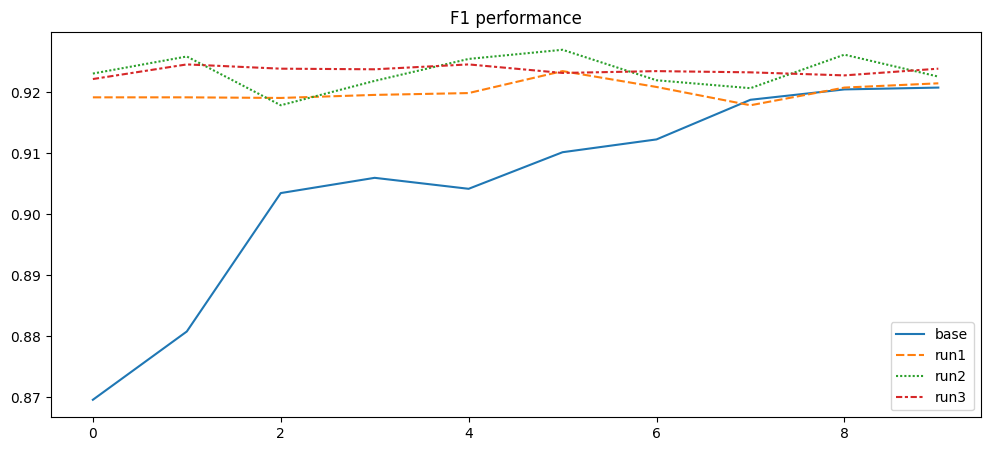

In [ ]:
# get different metrics for each run
loss = pd.read_csv('./resources/taggers/flair-ner-conll-eng/loss.tsv', delimiter='\t')
loss1 = pd.read_csv('./resources/taggers/flair-ner-conll-eng-0/loss.tsv', delimiter='\t')
loss2 = pd.read_csv('./resources/taggers/flair-ner-conll-eng-1/loss.tsv', delimiter='\t')
loss3 = pd.read_csv('./resources/taggers/flair-ner-conll-eng-2/loss.tsv', delimiter='\t')

# min/max/mean f1
min_f1 = min(min(loss['TEST_F1'].values.tolist()), min(loss1['TEST_F1'].values.tolist()),
            min(loss2['TEST_F1'].values.tolist()), min(loss3['TEST_F1'].values.tolist()))
max_f1 = max(max(loss['TEST_F1'].values.tolist()), max(loss1['TEST_F1'].values.tolist()),
            max(loss2['TEST_F1'].values.tolist()), max(loss3['TEST_F1'].values.tolist()))
mean_f1 = (loss['TEST_F1'].values.tolist()[-1]+loss1['TEST_F1'].values.tolist()[-1]+loss2['TEST_F1'].values.tolist()[-1]+loss3['TEST_F1'].values.tolist()[-1]) / 4

print('Min F1:', min_f1)
print('Max F1:', max_f1)
print('Mean F1:', mean_f1)

test_performances = {
    'epoch': [],
    'base': [],
    'run1': [],
    'run2': [],
    'run3': []
}
for i in range(MAX_EPOCHS):
  test_performances['epoch'].append(i)
  test_performances['base'].append(loss['TEST_F1'].values[i])
  test_performances['run1'].append(loss1['TEST_F1'].values[i])
  test_performances['run2'].append(loss2['TEST_F1'].values[i])
  test_performances['run3'].append(loss3['TEST_F1'].values[i])

test_performances = pd.DataFrame(test_performances)

print(test_performances)
import seaborn as sns
plt.figure(figsize=(12,5))
plt.title('F1 performance')
sns.lineplot(data=test_performances[['base','run1','run2','run3']])

The plot above shows the F1 score by epoch for each training run. The blue line represents the baseline run where it underperforms when compared to the other runs, as expected. Because we trained the same model three more times using the same number of epochs, each run starts with high F1 score yet they don't fluctuate. This indicates although the model did benefit from being trained more times, the improvement is not significant when compared to the rest of the runs given the Y axis' step is .1.

## (B) Downsampling

### Task

1. Downsample corpus to 25k line chunks
2. Train a system on the chunks incrementally
3. Plot F1 learning curve for as more training data is made available

In [ ]:
def create_chunks(chunk_file,chunk_size=25_000):
  """
  Create chunks given a train, test, and dev file.
  """
  chunks = {}
  with open(chunk_file, 'r') as file:
    lines = file.readlines()
    sentence = ''
    start = 0
    for i in list(range(0, len(lines), chunk_size)):
      chunks[i+chunk_size] = lines[start:i+chunk_size]

    return chunks
sentences = create_chunks(f'{datadir}/train.txt')

for key, value in sentences.items():
    with open(f'{datadir}/train_{key}.txt', 'w+') as file:
        for sentence in value:
            file.write(sentence)

f1_scores = {
    'chunk_size': [],
    'f1_score': [],
    'data_type': [],
}

### 25K chunks

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
path = './resources/taggers/flair-ner-conll-eng-25k'
with open(f'{path}/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

f1_scores['chunk_size'].append(25_000)
f1_scores['chunk_size'].append(25_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9796739990860885
Recall: 0.979642566322376
Precision: 0.9797508576523637


### 50K

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-200k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-50k'
f1_scores['chunk_size'].append(50_000)
f1_scores['chunk_size'].append(50_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9826639004868828
Recall: 0.9826211803025757
Precision: 0.9827398357725816


### 75K

In [ ]:
# TASK 1
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-75k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-75k'
f1_scores['chunk_size'].append(75_000)
f1_scores['chunk_size'].append(75_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9788482981361262
Recall: 0.9789139844854926
Precision: 0.9789557114557522


### 100k

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-100k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-100k'
f1_scores['chunk_size'].append(100_000)
f1_scores['chunk_size'].append(100_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.980315585610431
Recall: 0.9801997171388163
Precision: 0.9804858034829335


### 125k

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-125k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-125k'
f1_scores['chunk_size'].append(125_000)
f1_scores['chunk_size'].append(125_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9797541902840272
Recall: 0.9793425620366005
Precision: 0.980395296594649


### 150k

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-150k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-150k'
f1_scores['chunk_size'].append(150_000)
f1_scores['chunk_size'].append(150_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9810005484479615
Recall: 0.9807354390777011
Precision: 0.9813543461916047


### 175k

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-175k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-175k'
f1_scores['chunk_size'].append(175_000)
f1_scores['chunk_size'].append(175_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9823672195770078
Recall: 0.9821497449963571
Precision: 0.9826751189295653


### 200k

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-200k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-200k'
f1_scores['chunk_size'].append(200_000)
f1_scores['chunk_size'].append(200_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.9826639004868828
Recall: 0.9826211803025757
Precision: 0.9827398357725816


### 225k

In [ ]:
# TASK 1

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
with open('./resources/taggers/flair-ner-conll-eng-225k/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

path = './resources/taggers/flair-ner-conll-eng-225k'
f1_scores['chunk_size'].append(225_000)
f1_scores['chunk_size'].append(225_000)
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_scores['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_scores['data_type'].append('dev')
f1_scores['data_type'].append('test')

F1: 0.983018693125926
Recall: 0.9828997557107959
Precision: 0.9831704977886452


<Axes: xlabel='chunk_size', ylabel='f1_score'>

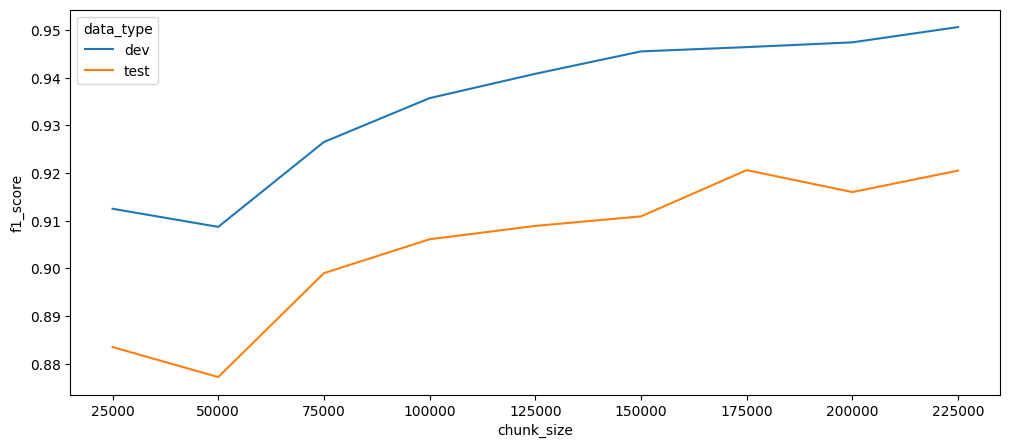

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=f1_scores, x='chunk_size', y='f1_score', hue='data_type')

The plot above shows the F1 score as more data becomes available. With the exception of 50k samples, on each increment the model yields a higher F1 score. This is expected given a model will almost always yield better results with good abd vast training data.

## (C) Update Training Data

### Tasks

1. Remove variant entity types ENT (i.e., map B-PER to B-ENT, I-PER to I-ENT, etc.) from training and testing sets
3. Retrain the system on the new data, using the same number of iterations as you did in your first training. Compare the scores in overall precision, recall, and F1, when type information is included (using your base run) against this new run that maps all types to ENT
2. Compare and describe why you think there is/is not a difference

In [ ]:
# remove variants
# remove specific entity types from test data
def remove_specific_entity_type(file_name):
    """
    Remove specific entity type
    (i.e., map B-PER to B-ENT, I-PER to I-ENT, etc.)
    """
    lines = open(file_name, 'r').readlines()
    def change_type(item: str):
        ent_type = item.split(' ')[-1].strip('\n')
        if ent_type in ['B-LOC', 'B-PER', 'I-PER', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG']:
            item = item.split(' ')[:-1]
            item.append(ent_type.split('-')[0]+'-ENT\n')
            return " ".join(item)
        return item

    return list(map(change_type, lines))

with open(f'{datadir}/train_ent_mod.txt', 'w+') as file:
    for line in remove_specific_entity_type(f'{datadir}/train.txt'):
      file.write(line)

with open(f'{datadir}/test_ent_mod.txt', 'w+') as file:
    for line in remove_specific_entity_type(f'{datadir}/test.txt'):
      file.write(line)

with open(f'{datadir}/valid_ent_mod.txt', 'w+') as file:
    for line in remove_specific_entity_type(f'{datadir}/valid.txt'):
      file.write(line)

In [ ]:
# define type
label_type = 'ner'
# define corpus
columns = {0: 'text', 1: 'pos', 2: 'chunk', 3: 'ner'}
corpus = ColumnCorpus(datadir, columns,
                      train_file=f'{datadir}/train_ent_mod.txt',
                      dev_file=f'{datadir}/valid_ent_mod.txt',
                      test_file=f'{datadir}/test_ent_mod.txt'
                  )
label_dict = corpus.make_label_dictionary(
    label_type=label_type,
    add_unk=False
)
# create embeddings
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)
# define tagger for NER
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type)
# trainer
trainer = ModelTrainer(tagger, corpus)

# 7. Train the model
EPOCHS=10
MAX_EPOCHS=EPOCHS
trainer.train(f'{labdir}/resources/taggers/{runname}-ent-mod',
              learning_rate=0.1,
              mini_batch_size=32,
              save_model_each_k_epochs=1,
              monitor_test=True,
              max_epochs=MAX_EPOCHS,
            )

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import pandas as pd
# read test.tsv preds
test_preds = []
path='./resources/taggers/flair-ner-conll-eng-ent-mod'
with open(f'{path}/test.tsv', 'r') as file:
  for line in file.readlines():
    test_preds.append(line.strip('\n'))

# clean test predictions
test_preds = list(map(lambda x: x.split(' '), test_preds))
test_preds = pd.DataFrame(test_preds, columns=['text','truth','pred'])
test_preds.dropna(inplace=True) # drop empty rows
test_preds['class_truth'] = test_preds['truth'].apply(lambda x: x.split('-')[-1])
test_preds['class_pred'] = test_preds['pred'].apply(lambda x: x.split('-')[-1])
labels = list(test_preds['class_pred'].unique())
# get overall test metrics
precision_overall = precision_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
recall_overall = recall_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')
f1_overall = f1_score(test_preds['class_truth'], test_preds['class_pred'], average='weighted')

print('F1:', f1_overall)
print('Recall:', recall_overall)
print('Precision:', precision_overall)

f1_score_mod = {
    'f1_score': [],
    'data_type': [],
    'chunk_size': []
}

f1_score_mod['chunk_size'].append(220_000)
f1_score_mod['chunk_size'].append(220_000)
f1_score_mod['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['DEV_F1'].values.tolist()[-1])
f1_score_mod['f1_score'].append(pd.read_csv(f'{path}/loss.tsv', delimiter='\t')['TEST_F1'].values.tolist()[-1])
f1_score_mod['data_type'].append('dev-ent-mod')
f1_score_mod['data_type'].append('test-ent-mod')

F1: 0.99062954524872
Recall: 0.9905927227531822
Precision: 0.9907072203503501


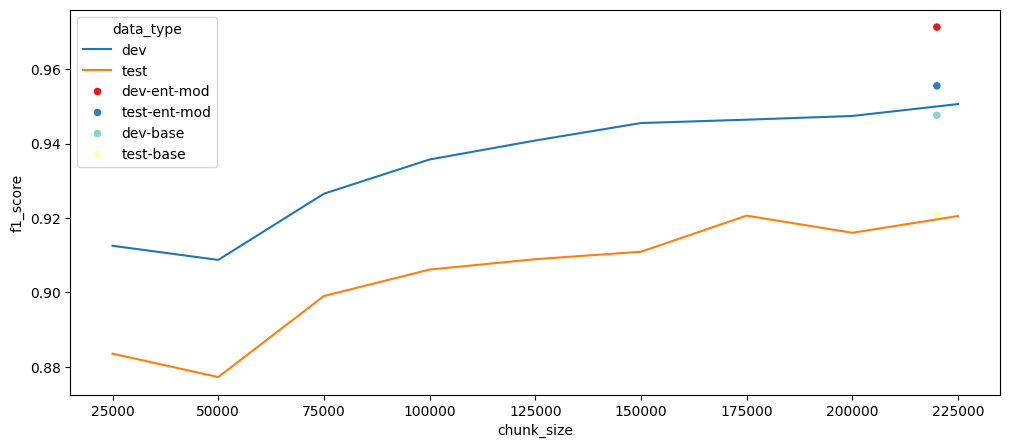

In [ ]:
# Create a bar plot to compare mod with previous chunked runs
plt.figure(figsize=(12, 5))
sns.lineplot(data=f1_scores, x='chunk_size', y='f1_score', hue='data_type')
with sns.color_palette("Set1"):
  sns.scatterplot(data=f1_score_mod, x='chunk_size', y='f1_score', hue='data_type')
with sns.color_palette("Set3"):
  sns.scatterplot(data=f1_score_base, x='chunk_size', y='f1_score', hue='data_type')

The plot above shows the F1 score for all our runs.
The lines plot the base model as data becomes available.
The yellow and green dot pair plot the base run's F1 score. These metrics match up with the last run from the chunked set given the last chunk contains all of the training data.
The blue and red dot pair plot the F1 score from the model that had a less specific training data, i.e. removing entity types. It makes sense the model without specific entity types would yield higher metrics given the model is predicting on less labels. Mathematically it allows the model to assign a higher score to fewer classes. If the model only has to predict between ENT and O, it will intuitively yield better results given it yields good results when specifying the specific entity type.

## (D) Test Model on Custom Data

### Tasks

1. Create a new test file containing at least at ten sentences including least ten named entities of each of the three types PER, ORG, and LOC

2. Run the tagger from the best saved model on your test examples

In [ ]:
from flair.splitter import SegtokSentenceSplitter
from textwrap import wrap

splitter = SegtokSentenceSplitter()

# define sentences
sentences = [
    "Last week my cousin Julio flew to Chicago via united airlines.",
    "Scooby is such a good dog, he never pees inside the house!",
    "Last week I met a couple of friends at AMSO and had a great time.",
    "I look forward to going to PR next year.",
    "My girlfriend told me New York is over rated.",
    "When's the last time Dr. Ramely saw you in the hospital?",
    "Yesterday I went to BoA and they said my account was empty!",
    "I always enjoy a good movie, specially those done by A24.",
    "These past couple of weeks have been tough for Florida due to the recent hurricanes milton and helene.",
    "Yesterday I saw my teacher at publix shopping with their partner.",
    "My pet rabbit Jack almost bit Dan's dog."
]
sentences = splitter.split(" ".join(sentences))

best_model_runname='flair-ner-conll-eng-ent-mod'
model = SequenceTagger.load(f'{labdir}/resources/taggers/{best_model_runname}/final-model.pt')

# predict the tags
model.predict(sentences)
# iterate through sentences and print predicted labels
for sentence in sentences:
    print('\n'.join(wrap(sentence.to_tagged_string())),'\n')

2024-10-21 16:36:35,728 SequenceTagger predicts: Dictionary with 7 tags: O, S-ENT, B-ENT, E-ENT, I-ENT, <START>, <STOP>
Sentence[12]: "Last week my cousin Julio flew to Chicago via united
airlines." → ["Julio"/ENT, "Chicago"/ENT] 

Sentence[14]: "Scooby is such a good dog, he never pees inside the
house!" → ["Scooby"/ENT] 

Sentence[16]: "Last week I met a couple of friends at AMSO and had a
great time." → ["AMSO"/ENT] 

Sentence[10]: "I look forward to going to PR next year." → ["PR"/ENT] 

Sentence[10]: "My girlfriend told me New York is over rated." → ["New
York"/ENT] 

Sentence[13]: "When's the last time Dr. Ramely saw you in the
hospital?" → ["Dr. Ramely"/ENT] 

Sentence[13]: "Yesterday I went to BoA and they said my account was
empty!" → ["BoA"/ENT] 

Sentence[13]: "I always enjoy a good movie, specially those done by
A24." → ["A24"/ENT] 

Sentence[19]: "These past couple of weeks have been tough for Florida
due to the recent hurricanes milton and helene." → ["Florida"/ENT,
"milt

The model used for this task was the generic entity recognizer. The model yielded correct entities when the sentences were gramatically correct, i.e. each entity had proper capitalization. For some entities, I either abbreviated them or wrote them in lower case. For the ones that I wrote in lower case the model failed to capture some, specifically hurricane helene and united airlines.

This shouts that the model can be great in a controlled environment, where every sentence is properly formatted. Given it failed to recognize the other entities I presume the model would yield far from accurate results when tested against data sources such as X (Twitter). Even though it would be great to create a model that is general for every type of literature, we can build great specific models for different tasks and perform an ensemeble technique down a pipeline.

# EOF